# Theory

## SABR Normal Implied Volatility 

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


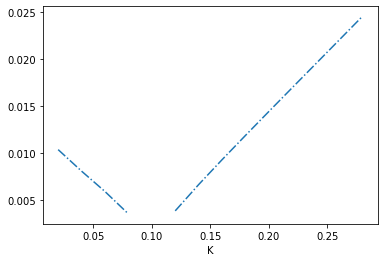

In [13]:
import numpy as np
from pandas import DataFrame 

# def sigma(K, F, alpha, beta, nu, rho, T):
#     z = nu*(F-K)/((alpha)*(F*K)**(0.5*beta))
#     x = np.log((np.sqrt(1-2*rho*z+z**2)+z-rho)/(1-rho))
#     res = (alpha*(1-beta)*(F-K)*z)/((F**(1-beta) - K**(1-beta))*x)*(1 + T*(-(alpha**2)*beta*(2-beta)/(24*((F*K)**(1-beta))) + 0.25*rho*beta*nu*alpha/((F*K)**(0.5*(1-beta))) + ((2-3*rho**2)*(nu**2))/24 ))
#     return res

def sigma(K, F, alpha, beta, nu, rho, T):
    z = nu*(F-K)/(alpha*(F*K)**(0.5*beta))
    x = np.log((np.sqrt(1-2*rho*z+z**2) + z - rho)/(1-rho))
    res = (alpha*(1-beta)*(F-K)*z)/((F**(1-beta) - K**(1-beta))*x)*(1 + T*(-(alpha**2)*beta*(2-beta)/(24*((F*K)**(1-beta))) + 0.25*rho*beta*nu*alpha/((F*K)**(0.5*(1-beta))) + ((2-3*rho**2)*(nu**2))/24 ))
    return res

def plot():
    alpha = 0.006009
    beta = 0.99
    F = 0.1
    T = 1
    nu = 0.68
    rho = 0.07
    
    DataFrame([(K, sigma(K, F, alpha, beta, nu, rho, T)) for K in np.arange(0, 0.3, 0.02)], columns=['K', 'sigma']).set_index('K').plot(style='-.', legend=None)
    
plot()

## BM Quadratic Variation

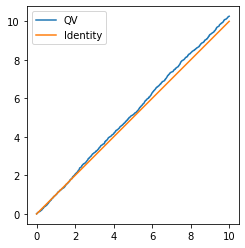

In [1]:
import numpy as np
from pandas import DataFrame

T = 10
n = 2500
dt = T/n

ax = DataFrame({'QV': (np.random.normal(0, np.sqrt(dt), n)**2).cumsum(), 
                'Identity': np.arange(dt, T+dt, dt)
               }, 
               index=np.arange(dt, T+dt, dt)).plot()
ax.set_aspect(1)


## SV Models

All models below are in the risk-neutral world and there can be a price-volatility correlation, meaning $dZ_tdW_t = \rho dt$.

![](../fig/sv.png)


From wikipedia: 
[SV Models](https://en.wikipedia.org/wiki/Stochastic_volatility), 
[CEV](https://en.wikipedia.org/wiki/Constant_elasticity_of_variance_model), 
[LV](https://en.wikipedia.org/wiki/Local_volatility), 
[SABR](https://en.wikipedia.org/wiki/SABR_volatility_model)


[GARCH(1, 1) limiting case derivation](https://math.berkeley.edu/~btw/thesis4.pdf)


MD 表 + 連結 + 數學符號 publish 之後會爛掉。這裡放的是圖。原本的 code 在下面被 comment out。圖其實可以不用存起來，直接 snipping tool 剪下之後在 cell 裡貼上就可以了

<!--
|Model| Dynamics | Speed Log Return QV Increase | Note
|--|--|--|--|
|[CEV](https://en.wikipedia.org/wiki/Constant_elasticity_of_variance_model)|$$dS_t = rS_t dt + \sigma S_t^{\beta} dW_t$$ | $$\sigma^2S_t^{2(\beta -1)}$$ | $$\beta< 1: \text{leverage effect; }\beta> 1: \text{inverse leverage effect}$$ |
|[LV](https://en.wikipedia.org/wiki/Local_volatility)| $$dS_t = rS_t dt + \sigma(t, S_t) S_t dW_t$$ | $$\sigma^2(t, S_t)$$ ||
|Heston|$$
\begin{cases}
dS_t = rS_tdt + \sqrt{V_t}S_t dW_t\\
dV_t = \theta(\kappa - V_t)dt + \sigma\sqrt{V_t} dZ_t
\end{cases}
$$| $$V_t$$ | $$V_t \text{ accumulates QV at the speed } \sigma^2 V_t$$ |
|[SABR](https://en.wikipedia.org/wiki/SABR_volatility_model)|$$
\begin{cases}
dF_t = \sigma_tF_t^{\beta} dW_t\\
d\sigma_t = \alpha\sigma_t dZ_t
\end{cases}
$$| $$\sigma_t^2F_t^{2(\beta -1)}$$ | $$\sigma_t \text{ accumulates QV at the speed } \alpha^2 \sigma_t^2$$ |
| GARCH(1, 1)|$$
dV_t = \theta(\kappa-V_t)dt + \sigma V_t dW_t
$$| $$?$$ | $$V_t \text{ accumulates QV at the speed } \sigma^2 V_t^2$$ Derivation of limiting case see [here](https://math.berkeley.edu/~btw/thesis4.pdf)|
-->

## Empirically...

* The log return of S&P 500 doesn't accumulate QV at a constant rate $\sigma^2$ per unit time as it's assumed in the Black-Scholes model
* The Heston model assumes that the log return accumulates QV at the rate of the volatility $V_t$, and the volatility accumulates QV at the rate of $\sigma^2 V_t$. So the speed the log return accumulates QV is a constant times the speed the volatility accumulates QV. 

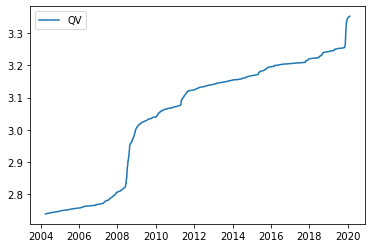

In [3]:
from pandas import DataFrame
import pandas as pd
import numpy as np

# data from 1928/1/1 - 2020/6/1

df = pd.read_csv('../data/^GSPC.csv').set_index('Date')
df = np.log(df[['Adj Close']].pct_change()[1:] + 1)

log_return = df.values

n = len(log_return)
dt = 1/252
ax = DataFrame({'QV': (log_return**2).cumsum()}, index=np.arange(dt+1928, (n+1)*dt+1928, dt)).tail(4000).plot()
# ax.set_aspect(1)



## [Penalty Method for American Put Pricing](https://cs.uwaterloo.ca/~paforsyt/con7.pdf)

\begin{align*}
V_{\tau} = \frac{\sigma^2S^2}{2}V_{SS} + rSV_S - rV + \rho\max(V^{*}-V, 0), 
\end{align*}
where $V^* = (K-S)^+$ is the payoff function, and $\rho$ is a large number. 

* Above the early exercise boundary, the penalty term disappears and the PDE reduces to the Black-Scholes PDE
* Below the boundary, the penalty term dominates and PDE is approximately $V_{\tau} = \rho(V^{*}-V)$ whose solution is $V = V^{*}$
